# 📌 Preparação das Tabelas Temporárias (TempViews)

Nessa etapa iniciaremos a preparação dos dados para a Camada Gold (Data Warehouse).

- 🔶 Ler os arquivos no DBFS (para não ficar lendo toda hora do S3 e consequentemente aumentar o custo por leitura)
- 🔶 Criar nossas Views Temporarias
- 🔶 Criar nossas View Temporaria da Classificação Detalhada


## 🔶 Leitura dos Arquivos no DBFS

### 🔹 Dataframes das tabelas

In [0]:
# Ler os dados do DBFS em vez do S3
df_todas_partidas = spark.read.parquet("dbfs:/mnt/silver_temp/todas_partidas")
df_classificacao = spark.read.parquet("dbfs:/mnt/silver_temp/classificacao")
df_estatisticas = spark.read.parquet("dbfs:/mnt/silver_temp/estatisticas")

print('✅ Dataframes criado com sucesso a partir do DBFS')

✅ Dataframes criado com sucesso a partir do DBFS


## 🔶 Criação das Views Temporárias

### 🔹 TempViews Principais

In [0]:
# Recriar as views temporárias
df_classificacao.createOrReplaceTempView("classificacao")
df_estatisticas.createOrReplaceTempView("estatisticas")
df_todas_partidas.createOrReplaceTempView("todas_partidas")


### 🔹 TempView 'Base' (CTE)
- 📍 Essa view será a nossa Classificação só que um pouco resumida
- 📍 Também adicionamos uma coluna `tier_clubes` para separar os clubes por Tier

In [0]:
%sql
-- Criando a CTE (Common Table Expression) Base para calcular os TIERs dos clubes
CREATE OR REPLACE TEMP VIEW Base AS
SELECT 
    c.posicao,        -- Posição final do clube no campeonato
    c.clube,          -- Nome do clube
    c.pontuacao,
    -- Definição do TIER com base na posição na tabela
    CASE
        WHEN c.posicao BETWEEN 1 AND 5 THEN 'TIER S'   -- Top 3 clubes
        WHEN c.posicao BETWEEN 6 AND 10 THEN 'TIER A'   -- Do 4º ao 8º colocado
        WHEN c.posicao BETWEEN 11 AND 15 THEN 'TIER B'  -- Do 9º ao 16º colocado
        ELSE 'TIER C'                                  -- Últimos colocados (zona de rebaixamento)
    END AS tier_clubes,
    c.vitorias,
    c.empates,
    c.derrotas,    
    c.gols_marcados,  -- Total de gols marcados na temporada
    c.gols_sofridos   -- Total de gols sofridos na temporada
FROM classificacao AS c;

### 🔹 TempView 'Medias_Tier' (CTE)
- 📍 Essa view será usada para calcular a médias de gols marcados e sofridos por cada TIER

In [0]:
%sql
-- Criando a CTE (Common Table Expression) Medias_Tier para calcular a média de gols marcados por TIER
CREATE OR REPLACE TEMP VIEW Medias_Tier AS
SELECT 
    tier_clubes,                      -- Agrupa os clubes por TIER
    ROUND(AVG(gols_marcados),2) AS avg_gols_marcados_tier,  -- Calcula a média de gols marcados dentro de cada TIER
    ROUND(AVG(gols_sofridos),2) AS avg_gols_sofridos_tier  -- Calcula a média de gols sofridos dentro de cada TIER
FROM Base
GROUP BY tier_clubes;

### 🔹 TempView 'Medias_Geral' (CTE)
- 📍 Já essa View iremos calcular a Média geral de Gols Marcados e Sofridos de todas as equipes da competição

In [0]:
%sql
-- Criando a CTE (Common Table Expression) Media_Geral para calcular a média geral de gols marcados por todos os clubes
CREATE OR REPLACE TEMP VIEW Media_Geral AS
SELECT 
    ROUND(AVG(gols_marcados),2) AS avg_gols_marcados_geral,
    ROUND(AVG(gols_sofridos),2) AS avg_gols_sofridos_geral
FROM Base;

### 💠 TempView Classificacao_Tier (Query final com todas as TempViews)

- 📍 Por fim criamos a nossa TempView juntados todas as outras criadas.
- 📍 Criamos separadamente para que fique mais organizado e facil de interpretar

In [0]:
%sql
-- Query final para juntar todas as informações
CREATE OR REPLACE TEMP VIEW Classificacao_Tier AS
SELECT 
    b.posicao,        -- Posição final do clube no campeonato
    b.clube,          -- Nome do clube
    b.pontuacao,
    b.tier_clubes,
    b.vitorias,
    b.empates,
    b.derrotas,    
    b.gols_marcados,                    -- Total de gols marcados na temporada
    m.avg_gols_marcados_tier,           -- Adiciona a média de gols do TIER do clube
    g.avg_gols_marcados_geral,          -- Adiciona a média geral de gols de todos os clubes
    b.gols_sofridos,                    -- Total de gols sofridos na temporada    
    m.avg_gols_sofridos_tier,           -- Adiciona a média de gols sofridos do TIER do clube
    g.avg_gols_sofridos_geral           -- Adiciona a média geral de gols sofridos de todos os clubes
FROM Base b
LEFT JOIN Medias_Tier m ON b.tier_clubes = m.tier_clubes  -- Junta a média de gols do TIER correspondente
LEFT JOIN Media_Geral g ON 1=1;  -- Junta a média geral de gols para todas as linhas (CROSS JOIN)

### 💠 TempView 'Estatisticas_PorClube'

- Refere-se ao DataFrame 'estatisticas'
- Agrupamos (`GROUP BY`) somente pelo Clube, pois é interessante somente os números gerais de cada Clube ao fim da competição 

In [0]:
 %sql
-- Query final para juntar todas as informações
CREATE OR REPLACE TEMP VIEW Estatisticas_PorClube AS
SELECT
    e.clube, 
    ROUND(sum(e.Assitencias), 0) AS ass, 
    ROUND(SUM(e.penaltis_batidos), 0) AS penaltis_batidos,  
    ROUND(SUM(e.penaltis_tentados), 0) AS penaltis_tentados, 
    ROUND(sum(e.total_chutes), 0) AS total_chutes,
    ROUND(sum(e.Chutes_a_Gol), 0) AS chutes_gol,
    ROUND(sum(e.toques_na_bola), 0) AS toques_na_bola,
    ROUND(sum(e.desarmes), 0) AS desarmes,
    ROUND(sum(e.interceptacoes), 0) AS interceptacoes,
    ROUND(sum(e.bloqueios), 0) AS bloqueios,
    ROUND(SUM(e.Gols_Esperados), 2) AS gols_esperados,
    ROUND(SUM(e.Assistencias_Esperadas), 2) AS ass_esperadas,
    ROUND(sum(e.acoes_de_criacao), 0) AS acoes_de_criacao,
    ROUND(sum(e.acoes_de_gol), 0) AS acoes_de_gol,
    ROUND(sum(e.passes_completos), 0) AS passes_completos,
    ROUND(sum(e.Passes_Tentados), 0) AS passes_tentados,
    ROUND(sum(e.Passes_Progressivos), 0) AS passes_progressivos,
    ROUND(sum(e.Conducoes_de_Bola), 0) AS conducoes_de_bola,
    ROUND(sum(e.Conducoes_Progressivas), 0) AS conducoes_progressivas,
    ROUND(sum(e.Dribles_Tentados), 0) AS dribles_tentados,
    ROUND(sum(e.Dribles_Completos), 0) AS dribles_completos
FROM estatisticas AS e
GROUP BY e.clube;

# 📌 Normalização das Métricas do Projeto

## 🔶 Normalização das Métricas Defensivas
Transformaremos diferentes métricas defensivas em uma escala comum de **0 a 10**, permitindo comparações mais justas entre os clubes.

---

### 🔢 Como funcionará a normalização?

#### ⚖️ Normalização Tradicional

A Normalização Tradicional é feita utilizando a fórmula:

![Normalização](https://github.com/Cavalheiro93/mvp-brasileirao-data-engineering/raw/main/images/notebook-images/Normalizacao.png)

Essa fórmula ajusta os valores para ficarem dentro do intervalo **0 a 10**.


#### **⚠️ Exceção para gols sofridos**

Como **menos gols sofridos** é **melhor**, aplicamos a inversão:

![Normalização Invertida](images/Normalizacao_invertida.jpg)

Isso garante que um time que sofreu menos gols tenha um valor **maior** na escala.

---

### 🏆 Explicação das Métricas Normalizadas
| Métrica            | Interpretação | Peso
|--------------------|---------------|----- |
| `norm_gols_sofridos` | Times que sofreram menos gols terão valores maiores. | 60% 
| `norm_desarmes` | Times que fizeram mais desarmes terão valores maiores. | 25% 
| `norm_interceptacoes` | Times que interceptaram mais passes terão valores maiores. | 10% 
| `norm_bloqueios` | Times que bloquearam mais chutes terão valores maiores. | 5% 

---

### 🔹 Cálculo da Normalização Defensiva

In [0]:

%sql
-- Criando a VIEW com a normalização das métricas defensivas
CREATE OR REPLACE TEMP VIEW Normalizacao_Defensiva AS
SELECT 
    c.clube,

    -- Normalização das métricas para escala de 0 a 10 (arredondada para 2 casas decimais)

    -- 'gols_sofridos' aplicamos a Normalização Invertida
    -- Ou seja, menos gols sofridos é melhor!
    ROUND((10 - (c.gols_sofridos - MIN(c.gols_sofridos) OVER()) / 
         (MAX(c.gols_sofridos) OVER() - MIN(c.gols_sofridos) OVER()) * 10), 2) 
         AS norm_gols_sofridos,

    -- Para os demais, aplicamos a Normalização Tradicional
    ROUND(((e.desarmes - MIN(e.desarmes) OVER()) / 
         (MAX(e.desarmes) OVER() - MIN(e.desarmes) OVER()) * 10), 2) 
         AS norm_desarmes,

    ROUND(((e.interceptacoes - MIN(e.interceptacoes) OVER()) / 
         (MAX(e.interceptacoes) OVER() - MIN(e.interceptacoes) OVER()) * 10), 2) 
         AS norm_interceptacoes,

    ROUND(((e.bloqueios - MIN(e.bloqueios) OVER()) / 
         (MAX(e.bloqueios) OVER() - MIN(e.bloqueios) OVER()) * 10), 2) 
         AS norm_bloqueios

FROM Classificacao_Tier c
LEFT JOIN Estatisticas_PorClube e ON c.clube = e.clube;


### 🔹 Pesos da Normalização Defensiva

In [0]:
%sql
-- Criando a VIEW com o cálculo do Score Defensivo
CREATE OR REPLACE TEMP VIEW Score_Defensivo AS
SELECT 
    n.clube,
    n.norm_gols_sofridos,
    n.norm_desarmes,
    n.norm_interceptacoes,
    n.norm_bloqueios,

    -- Cálculo do SCORE DEFENSIVO (média ponderada das métricas normalizadas)
    ROUND((
        (n.norm_gols_sofridos * 0.6) + -- Peso 60% para gols sofridos (quanto menor, melhor)
        (n.norm_desarmes * 0.25) + -- Peso 25% para desarmes
        (n.norm_interceptacoes * 0.10) + -- Peso 10% para interceptações
        (n.norm_bloqueios * 0.05) -- Peso 5% para bloqueios
    ),2) AS score_defensivo

FROM Normalizacao_Defensiva n;

## 🔶 Normalização das Métricas Ofensivas

Transformaremos diferentes métricas ofensivas em uma escala comum de **0 a 10**, permitindo comparações mais justas entre os clubes.

---



### 🔢 Como funcionará a normalização?

#### ⚖️ Normalização Tradicional

Usaremos a fórmula tradicional para normalizar os valores entre 0 e 10:

![Normalização](files/tables/Normalizacao.png)

Nesse caso, **quanto maior o valor original**, melhor o desempenho ofensivo. Portanto, **não será necessário inverter nenhuma métrica**.

---


### 🏆 Métricas Selecionadas para Ofensivo

| Métrica                   | Interpretação                                                    | Peso |
|---------------------------|------------------------------------------------------------------|------|
| `gols_marcados`           | Quantidade de gols marcados                                      | 25%  |
| `assistencias`            | Capacidade de criação de jogadas com resultado                   | 10%  |
| `penaltis_batidos`        | Presença ofensiva na área adversária                             | 2,5% |
| `total_chutes`            | Volume de tentativas ofensivas                                   | 2,5% |
| `chutes_a_gol`            | Qualidade das finalizações                                       | 7,5% |
| `xG` ou `gols_esperados`  | Qualidade esperada das finalizações                              | 15%  |
| `xA` ou `Ass_esperados`   | Qualidade esperada das assistências                              | 2,5% |
| `acoes_de_criacao`        | Jogadas que geram oportunidades                                  | 7,5% |
| `acoes_de_gol`            | Jogadas que terminam em gols ou quase isso                       | 15%  |
| `eficiência`              | Quantos gols foram convertidos em relação a gols esperados       | 15%  |

---

### 🔹 Cálculo da Normalização Ofensiva

In [0]:

%sql
-- Criando a VIEW com a normalização das métricas Ofensivas
CREATE OR REPLACE TEMP VIEW Normalizacao_Ofensiva AS
SELECT 
    c.clube,

    -- Normalização das métricas para escala de 0 a 10 (arredondada para 2 casas decimais)

    -- 'gols_marcados' aplicamos a Normalização Invertida
    -- Ou seja, menos gols sofridos é melhor!
    ROUND(((c.gols_marcados - MIN(c.gols_marcados) OVER()) / 
         (MAX(c.gols_marcados) OVER() - MIN(c.gols_marcados) OVER()) * 10), 2) 
         AS norm_gols_marcados,

    -- Para os demais, aplicamos a Normalização Tradicional
    --- Assistencias
    ROUND(((e.Ass - MIN(e.Ass) OVER()) / 
         (MAX(e.Ass) OVER() - MIN(e.Ass) OVER()) * 10), 2) 
         AS norm_Ass,

    --- Penaltis Batidos
    ROUND(((e.penaltis_batidos - MIN(e.penaltis_batidos) OVER()) / 
         (MAX(e.penaltis_batidos) OVER() - MIN(e.penaltis_batidos) OVER()) * 10), 2) 
         AS norm_penaltis_batidos,

    --- Total de Chutes
    ROUND(((e.total_chutes - MIN(e.total_chutes) OVER()) / 
         (MAX(e.total_chutes) OVER() - MIN(e.total_chutes) OVER()) * 10), 2) 
         AS norm_total_chutes,

    --- Chutes a Gol
    ROUND(((e.chutes_gol - MIN(e.chutes_gol) OVER()) / 
         (MAX(e.chutes_gol) OVER() - MIN(e.chutes_gol) OVER()) * 10), 2) 
         AS norm_chutes_gol, 

    --- xG ou Gols Esperados
    ROUND(((e.gols_esperados - MIN(e.gols_esperados) OVER()) / 
         (MAX(e.gols_esperados) OVER() - MIN(e.gols_esperados) OVER()) * 10), 2) 
         AS norm_gols_esperados,
                  
    --- xA ou Assistencias Esperadas
    ROUND(((e.ass_esperadas - MIN(e.ass_esperadas) OVER()) / 
         (MAX(e.ass_esperadas) OVER() - MIN(e.ass_esperadas) OVER()) * 10), 2) 
         AS norm_ass_esperadas,

    --- Ações de Criação
    ROUND(((e.acoes_de_criacao - MIN(e.acoes_de_criacao) OVER()) / 
         (MAX(e.acoes_de_criacao) OVER() - MIN(e.acoes_de_criacao) OVER()) * 10), 2) 
         AS norm_acoes_de_criacao,

    --- Ações de Gol
    ROUND(((e.acoes_de_gol - MIN(e.acoes_de_gol) OVER()) / 
         (MAX(e.acoes_de_gol) OVER() - MIN(e.acoes_de_gol) OVER()) * 10), 2) 
         AS norm_acoes_de_gol,

    --- Eficiencia
    ROUND((c.gols_marcados / NULLIF(e.gols_esperados, 0)), 2) AS eficiencia_finalizacao,

    ROUND((((c.gols_marcados / NULLIF(e.gols_esperados, 0)) - MIN((c.gols_marcados / NULLIF(e.gols_esperados, 0))) OVER()) / 
         (MAX((c.gols_marcados / NULLIF(e.gols_esperados, 0))) OVER() - MIN((c.gols_marcados / NULLIF(e.gols_esperados, 0))) OVER()) * 10), 2) 
         AS norm_eficiencia    

FROM Classificacao_Tier c
LEFT JOIN Estatisticas_PorClube e ON c.clube = e.clube;


### 🔹 Pesos da Normalização Ofensiva

In [0]:
%sql
-- Criando a VIEW com o cálculo do Score Ofensivo
CREATE OR REPLACE TEMP VIEW Score_Ofensivo AS
SELECT 
    n.clube,
    n.norm_gols_marcados,
    n.norm_Ass,
    n.norm_penaltis_batidos,
    n.norm_total_chutes,
    n.norm_chutes_gol,
    n.norm_gols_esperados,
    n.norm_ass_esperadas,
    n.norm_acoes_de_criacao,
    n.norm_acoes_de_gol,
    n.norm_eficiencia,

    -- Cálculo do SCORE Ofensivo (média ponderada das métricas normalizadas)
    ROUND((  
        (n.norm_gols_marcados * 0.25) +         
        (n.norm_Ass * 0.10) +                  
        (n.norm_penaltis_batidos * 0.025) +     
        (n.norm_total_chutes * 0.025) +         
        (n.norm_chutes_gol * 0.075) +           
        (n.norm_gols_esperados * 0.15) +       
        (n.norm_ass_esperadas * 0.025) +        
        (n.norm_acoes_de_criacao * 0.075) +     
        (n.norm_acoes_de_gol * 0.15) +         
        (n.norm_eficiencia * 0.15)             
    ), 2) AS score_ofensivo

FROM Normalizacao_Ofensiva n;


## 🔶 Normalização das Métricas de Criação

Transformaremos diferentes métricas de **criação de jogadas** em uma escala comum de **0 a 10**, permitindo entender quais clubes têm maior capacidade de construir oportunidades — mesmo que não convertam em gol.

---

### 🔢 Como funcionará a normalização?

Usaremos a fórmula tradicional de normalização:

![Normalização](files/tables/Normalizacao.png)

Nenhuma métrica aqui será invertida, pois **quanto mais, melhor**.

### 🏆 Métricas Selecionadas para Criação

| Métrica                  | Interpretação                               | Peso   |
|--------------------------|---------------------------------------------|------  |
| `assistencias`           | Resultado direto de criação bem-sucedida    | 30%    |
| `acoes_de_criacao`       | Volume de jogadas que geram oportunidades   | 30%    |
| `xA`                     | Qualidade esperada das assistências         | 25%    |
| `passes_completos`       | Participação ativa na construção            | 3,75%  |
| `passes_tentados`        | Volume total de tentativas ofensivas        | 3,75%  |
| `conducoes_de_bola`      | Participação individual na construção       | 3,75%  |
| `conducoes_progressivas` | Avanço real com a bola no pé                | 3,75%  |

### 🔹 Cálculo da Normalização de Criação

In [0]:
%sql
-- Criando a VIEW com a normalização das métricas de Criação
CREATE OR REPLACE TEMP VIEW Normalizacao_Criacao AS
SELECT 
    c.clube,

    -- Normalização das métricas para escala de 0 a 10 (sem inversão)
    
    -- Assistências
    ROUND(((e.Ass - MIN(e.Ass) OVER()) / 
        (MAX(e.Ass) OVER() - MIN(e.Ass) OVER()) * 10), 2) AS norm_assistencias,

    -- Ações de Criação
    ROUND(((e.acoes_de_criacao - MIN(e.acoes_de_criacao) OVER()) /
        (MAX(e.acoes_de_criacao) OVER() - MIN(e.acoes_de_criacao) OVER()) * 10), 2) AS norm_acoes_de_criacao,

    -- xA ou Assistências Esperadas
    ROUND(((e.ass_esperadas - MIN(e.ass_esperadas) OVER()) /
        (MAX(e.ass_esperadas) OVER() - MIN(e.ass_esperadas) OVER()) * 10), 2) AS norm_ass_esperadas,

    -- Passes Completos
    ROUND(((e.passes_completos - MIN(e.passes_completos) OVER()) /
        (MAX(e.passes_completos) OVER() - MIN(e.passes_completos) OVER()) * 10), 2) AS norm_passes_completos,

    -- Passes Tentados
    ROUND(((e.passes_tentados - MIN(e.passes_tentados) OVER()) /
        (MAX(e.passes_tentados) OVER() - MIN(e.passes_tentados) OVER()) * 10), 2) AS norm_passes_tentados,

    -- Conduções de Bola
    ROUND(((e.conducoes_de_bola - MIN(e.conducoes_de_bola) OVER()) /
        (MAX(e.conducoes_de_bola) OVER() - MIN(e.conducoes_de_bola) OVER()) * 10), 2) AS norm_conducoes_de_bola,

    -- Conduções Progressivas
    ROUND(((e.conducoes_progressivas - MIN(e.conducoes_progressivas) OVER()) /
        (MAX(e.conducoes_progressivas) OVER() - MIN(e.conducoes_progressivas) OVER()) * 10), 2) AS norm_conducoes_progressivas


FROM Classificacao_Tier c
LEFT JOIN Estatisticas_PorClube e ON c.clube = e.clube;


### 🔹 Pesos da Normalização de Criação

In [0]:
%sql
-- Criando a VIEW com o cálculo do Score de Criação (foco em efetividade)
CREATE OR REPLACE TEMP VIEW Score_Criacao AS
SELECT 
    n.clube,
    n.norm_assistencias,
    n.norm_acoes_de_criacao,
    n.norm_ass_esperadas,
    n.norm_passes_completos,
    n.norm_passes_tentados,
    n.norm_conducoes_de_bola,
    n.norm_conducoes_progressivas,

    -- Cálculo do SCORE DE CRIAÇÃO com pesos ajustados
    ROUND((
        (n.norm_assistencias * 0.30) +
        (n.norm_acoes_de_criacao * 0.30) +
        (n.norm_ass_esperadas * 0.25) +
        (n.norm_passes_completos * 0.0375) +
        (n.norm_passes_tentados * 0.0375) +
        (n.norm_conducoes_de_bola * 0.0375) +
        (n.norm_conducoes_progressivas * 0.0375)
    ), 2) AS score_criacao

FROM Normalizacao_Criacao n;

## 🔶 Gráficos de Score

### 📈Gráfico | Análise de Score Criação vs Score Ofensivo

#### 🔹Criação da TempView cruzando Score de Criação, Ofensivo e Defensivo

In [0]:
%sql
-- Cruzamento entre Score de Criação, Score Ofensivo e Score Defensivo
CREATE OR REPLACE TEMP VIEW Analise_Criacao_vs_Ofensivo AS
SELECT 
    o.clube,
    c.score_criacao,
    o.score_ofensivo,
    d.score_defensivo
FROM Score_Criacao c
JOIN Score_Ofensivo o ON c.clube = o.clube
JOIN Score_Defensivo d ON c.clube = d.clube;


#### 🔹 Plotagem do Gráfico de Dispersão

<command-4262808209481361>:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


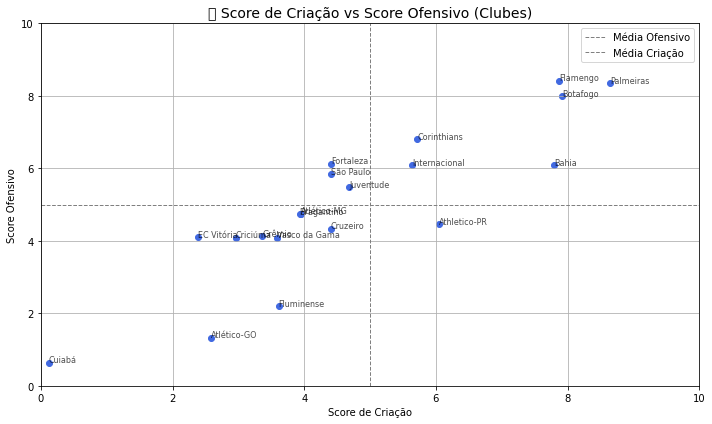

In [0]:
# Plotando com escala fixa
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Start a Spark session (only needed if this were standalone, included for context)
spark = SparkSession.builder.getOrCreate()

# Lê a TempView direto do Spark SQL
df = spark.sql("SELECT * FROM Analise_Criacao_vs_Ofensivo").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(df['score_criacao'], df['score_ofensivo'], color='royalblue')

# Anotações com os nomes dos clubes
for i, row in df.iterrows():
    plt.annotate(row['clube'], (row['score_criacao'], row['score_ofensivo']), fontsize=8, alpha=0.7)

plt.title('🎯 Score de Criação vs Score Ofensivo (Clubes)', fontsize=14)
plt.xlabel('Score de Criação')
plt.ylabel('Score Ofensivo')
plt.grid(True)

# Linhas de média
plt.axhline(5, color='gray', linestyle='--', linewidth=1, label='Média Ofensivo')
plt.axvline(5, color='gray', linestyle='--', linewidth=1, label='Média Criação')

# Escala de 0 a 10
plt.xlim(0, 10)
plt.ylim(0, 10)

plt.legend()
plt.tight_layout()
plt.show()


#### 🔹 Plotagem do gráfico de Radar comparativo entre clubes

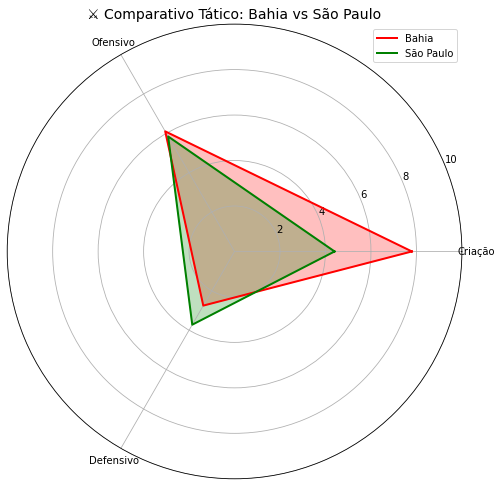

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Pega os dois clubes que você quer comparar
clubes = ["Bahia", "São Paulo"]

# Extrai os dados dos dois clubes
df_radar = df[df['clube'].isin(clubes)].set_index('clube')
categorias = ['Criação', 'Ofensivo', 'Defensivo']

# Garante a ordem correta dos valores
valores_sp = df_radar.loc["Bahia"][['score_criacao', 'score_ofensivo', 'score_defensivo']].tolist()
valores_pal = df_radar.loc["São Paulo"][['score_criacao', 'score_ofensivo', 'score_defensivo']].tolist()

# Fecha o radar (repetir o 1º valor no final)
valores_sp += [valores_sp[0]]
valores_pal += [valores_pal[0]]
angulos = np.linspace(0, 2 * np.pi, len(valores_sp))

# Plot
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

ax.plot(angulos, valores_sp, label='Bahia', color='red', linewidth=2)
ax.fill(angulos, valores_sp, color='red', alpha=0.25)

ax.plot(angulos, valores_pal, label='São Paulo', color='green', linewidth=2)
ax.fill(angulos, valores_pal, color='green', alpha=0.25)

ax.set_xticks(angulos[:-1])
ax.set_xticklabels(categorias)
ax.set_yticks([2, 4, 6, 8, 10])
ax.set_title('⚔️ Comparativo Tático: Bahia vs São Paulo', fontsize=14)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


# 📌 Criação dos Data marts

###  🔹Mart_Desempenho_Defensivo_Clubes 🔰

---

Preparando o Datamart de Desempenho Defensivo dos Clubes, que irá para o Redshift


In [0]:
%sql
CREATE OR REPLACE TEMP VIEW Mart_Desempenho_Defensivo_Clubes AS
SELECT 
    c.posicao,
    s.clube,
    c.tier_clubes,
    s.norm_gols_sofridos,
    s.norm_desarmes,
    s.norm_interceptacoes,
    s.norm_bloqueios,
    s.score_defensivo,
    'Defensivo' AS tipo_score    
FROM Score_Defensivo s
JOIN Classificacao_Tier c ON s.clube = c.clube;


### 🔹Mart_Desempenho_Ofensivo_Clubes ⚔️

---

Preparando o Datamart de Desempenho Ofensivo dos Clubes, que irá para o Redshift


In [0]:
%sql
CREATE OR REPLACE TEMP VIEW Mart_Desempenho_Ofensivo_Clubes AS
SELECT 
    c.posicao,
    s.clube,
    c.tier_clubes,
    s.norm_gols_marcados,
    s.norm_Ass AS norm_assistencias,
    s.norm_penaltis_batidos,
    s.norm_total_chutes,
    s.norm_chutes_gol,
    s.norm_gols_esperados,
    s.norm_ass_esperadas,
    s.norm_acoes_de_criacao,
    s.norm_acoes_de_gol,
    s.norm_eficiencia,
    s.score_ofensivo,
    'Ofensivo' AS tipo_score        
FROM Score_Ofensivo s
JOIN Classificacao_Tier c ON s.clube = c.clube;


### 🔹 Mart_Desempenho_Criacao_Clubes 🧠

---

Preparando o Datamart de Desempenho de Criação dos Clubes, que irá para o Redshift

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW Mart_Desempenho_Criacao_Clubes AS
SELECT 
    c.posicao,
    sc.clube,
    c.tier_clubes,
    sc.norm_assistencias,
    sc.norm_acoes_de_criacao,
    sc.norm_ass_esperadas,
    sc.norm_passes_completos,
    sc.norm_passes_tentados,
    sc.norm_conducoes_de_bola,
    sc.norm_conducoes_progressivas,
    sc.score_criacao,
    'Criacao' AS tipo_score        
FROM Score_Criacao sc
JOIN Classificacao_Tier c ON sc.clube = c.clube;


### 🔹Mart_Desempenho_Clubes 🧱

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW Mart_Desempenho_Clubes AS
SELECT 
    d.posicao,
    d.clube,
    d.tier_clubes,

    -- Métricas defensivas
    d.norm_gols_sofridos,
    d.norm_desarmes,
    d.norm_interceptacoes,
    d.norm_bloqueios,


    -- Métricas ofensivas
    o.norm_gols_marcados,
    o.norm_assistencias,
    o.norm_penaltis_batidos,
    o.norm_total_chutes,
    o.norm_chutes_gol,
    o.norm_gols_esperados,
    o.norm_ass_esperadas,
    o.norm_acoes_de_criacao,
    o.norm_acoes_de_gol,
    o.norm_eficiencia,

    -- Métricas de criação
    c.norm_passes_completos,
    c.norm_passes_tentados,
    c.norm_conducoes_de_bola,
    c.norm_conducoes_progressivas,

    -- SCORES
    d.score_defensivo,    
    o.score_ofensivo,
    c.score_criacao


FROM Mart_Desempenho_Defensivo_Clubes d
LEFT JOIN Mart_Desempenho_Ofensivo_Clubes o ON d.clube = o.clube
LEFT JOIN Mart_Desempenho_Criacao_Clubes c ON d.clube = c.clube;

# 📌 Salvando os Arquivs na Camada Gold 

### 🔹Geral - Salvando Datamart na camada Gold

In [0]:
df_gold = spark.sql("SELECT * FROM Mart_Desempenho_Clubes")

df_gold.write.mode("overwrite").parquet("s3a://mvp-brasileirao-2024/gold/Mart_Desempenho_Clubes")

### 🔹Classificacao_Tier -  - Salvando Datamart na camada Gold

In [0]:
df_gold = spark.sql("SELECT * FROM Classificacao_Tier")

df_gold.write.mode("overwrite").parquet("s3a://mvp-brasileirao-2024/gold/Classificacao_Tier")

### 🔹todas_partidas - Salvando Datamart na camada Gold

In [0]:
df_gold = spark.sql("SELECT * FROM todas_partidas")

df_gold.write.mode("overwrite").parquet("s3a://mvp-brasileirao-2024/gold/todas_partidas")